In [1]:
%load_ext autoreload
%autoreload 2
%cd '../HOTS'
%matplotlib inline

/Users/laurentperrinet/quantic/science/HomeHots/HOTS_clone_laurent/HOTS


In [2]:
import tonic
from TimeSurface import TimeSurface
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import os
import pickle
import datetime
from Network import network
from Tools import fit_jitter, signumber, netparam, fit_jitter

def printfig(fig, name):
    dpi_exp = None
    bbox = 'tight'
    #path = '../../paper/5f22d412742c360001c92b46/fig/'
    path = '../../GrimaldiEtAl2020HOTS_clone_laurent/fig'
    fig.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox, transparent=True)

# Stream.png

In [3]:
learningset = tonic.datasets.POKERDVS(save_to='../Data/', train = False,
                                transform=None)
loader = tonic.datasets.DataLoader(learningset, shuffle=True)

Using downloaded and verified file: ../Data/pips_test.tar.gz
Extracting ../Data/pips_test.tar.gz to ../Data/


In [4]:
print(learningset)

Dataset POKERDVS
    Number of datapoints: 20
    Root location: ../Data/


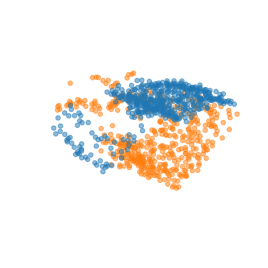

In [5]:
X_on = []
Y_on = []
T_on = []
X_off = []
Y_off = []
T_off = []
iev = 100
events, target = next(iter(loader))
target_event = events.shape[1]
target_event = 1000
while iev<target_event:
    x,y,t,p = events[0][iev][learningset.ordering.find("x")].item(), \
            events[0][iev][learningset.ordering.find("y")].item(), \
            events[0][iev][learningset.ordering.find("t")].item(), \
            events[0][iev][learningset.ordering.find("p")].item()
    if p:
        X_on.append(x)
        Y_on.append(abs(learningset.sensor_size[1]-y))
        T_on.append(t)
    else:
        X_off.append(x)
        Y_off.append(abs(learningset.sensor_size[1]-y))
        T_off.append(t)
    iev+=1
fig = plt.figure(figsize=(10,5))
sub1 = fig.add_subplot(1,2,1, projection="3d")
sub1.scatter(T_on, X_on, Y_on, cmap= plt.cm.plasma, alpha=0.5)
sub1.scatter(T_off, X_off, Y_off, cmap= plt.cm.plasma, alpha=0.5)
#sub1.arrow([0,max(T_off)], [0,0], [0,0])
sub1.view_init(10,-40)
sub1.grid(b = None)
sub1.set_xlabel('time')
sub1.axis('off')
plt.show()

In [6]:
printfig(fig, 'stream.png')

# Flux.png

In [7]:
learningset = tonic.datasets.NMNIST(save_to='../Data/', train = False,
                                transform=None)
loader = tonic.datasets.DataLoader(learningset, batch_size=1, shuffle=True)

Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


In [8]:
TS = TimeSurface(R=2,tau=5*10e3,camsize=[34,34])
events, target = next(iter(loader))
# target_event = 3300
flxT = TS.spatpmat.copy()
iev = 0
while iev<events.shape[1]:
    x,y,t,p = events[0][iev][learningset.ordering.find("x")].item(), \
                events[0][iev][learningset.ordering.find("y")].item(), \
                events[0][iev][learningset.ordering.find("t")].item(), \
                events[0][iev][learningset.ordering.find("p")].item(),
    flxT[p,x,y] = t
    ts, activ = TS.addevent(x,y,t,p)
    iev+=1

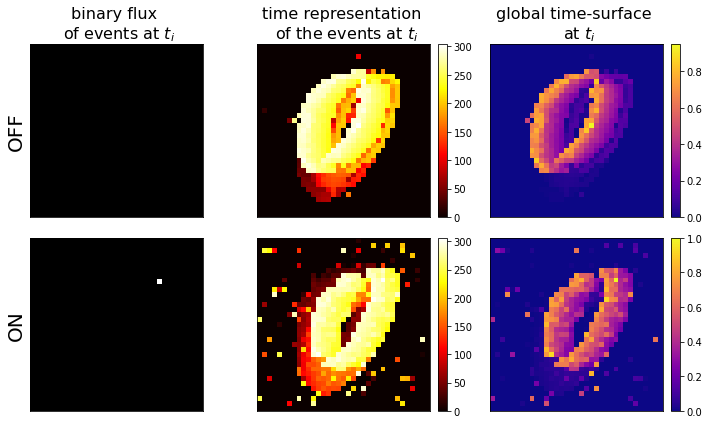

In [9]:
polaritiz = ['OFF','ON']
gamma = 1
fig, axs = plt.subplots(2,3,figsize=(10,6))

Ti = np.zeros(learningset.sensor_size)
singev = axs[abs(p-1),0].imshow(Ti.T, cmap='gray')
axs[abs(p-1),0].set_title('binary flux \n of events at $t_i$', fontsize=16)
axs[abs(p-1),0].set_ylabel(f'{polaritiz[abs(p-1)]}', fontsize=20)
axs[abs(p-1),0].set_xticks(())
axs[abs(p-1),0].set_yticks(())

Ti[x,y] = 1
singev = axs[p,0].imshow(Ti.T, cmap='gray')
#axs[p,0].set_title('binary flux of events at $t_i$', fontsize=16) #for NN
if p==0:
    axs[p,0].set_title('event recording at $t_i$', fontsize=16)
axs[p,0].set_ylabel(f'{polaritiz[p]}', fontsize=20)
axs[p,0].set_xticks(())
axs[p,0].set_yticks(())

for p in [0,1]:
    T = axs[p,1].imshow(flxT[p].T*1e-3, cmap='hot')
    #axs[p,1].set_title('T flux at $t_i$ (in $ms$)', fontsize=16) #for NN
    if p==0:
        axs[p,1].set_title('time representation \n of the events at $t_i$', fontsize=16)
    axs[p,1].set_xticks(())
    axs[p,1].set_yticks(())
    plt.colorbar(T, ax=axs[p,1], fraction=0.046, pad=0.04);
    
    S = axs[p,2].imshow(TS.spatpmat[p].T, cmap=plt.cm.plasma)
    #axs[p,2].set_title('S flux at $t_i$', fontsize=16) #for NN
    if p==0:
        axs[p,2].set_title('global time-surface \n at $t_i$', fontsize=16)
    axs[p,2].set_xticks(())
    axs[p,2].set_yticks(())
    cbar = plt.colorbar(S, ax=axs[p,2], fraction=0.046, pad=0.04);
    #cbar.set_label(fonsize=16)
    
fig.tight_layout()

In [10]:
printfig(fig, 'flux.pdf')

# Layers.png

In [11]:
timestr = '2021-02-16'

sigma = None
pooling = False
homeinv = False
jitter = False
tau = 5
krnlinit = 'rdn'
nblay = 3
nbclust = 4
filt = 2
name = 'homhots'

hotshom, homeotest_hotshom = netparam(name, filt, tau, nblay, nbclust, sigma, homeinv, jitter, timestr)

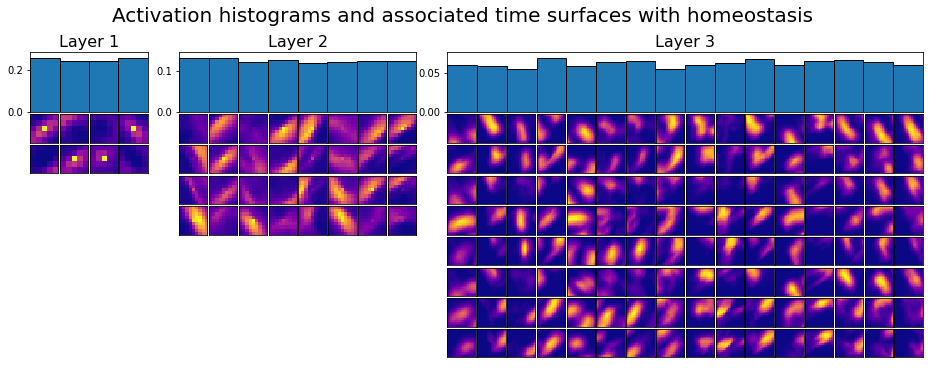

In [12]:
fig = hotshom.plotlayer()

In [13]:
printfig(fig, 'layerwiz.pdf')

In [14]:
name = 'hots'
hots, homeotest_hots = netparam(name, filt, tau, nblay, nbclust, sigma, homeinv, jitter, timestr)

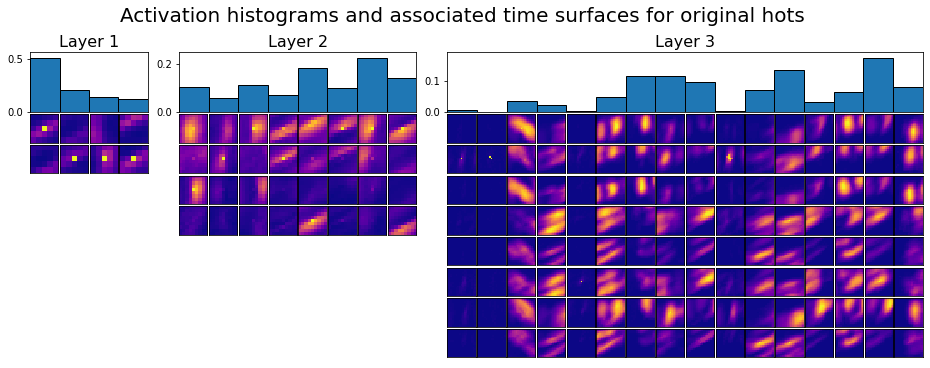

In [15]:
fig = hots.plotlayer()

In [16]:
printfig(fig, 'layerwizout.pdf')

# Jitter.png

In [17]:
dataset = 'nmnist'
records_path = '../Records'
timestr = '2021-02-16'
homeo = False
homeotest = False
sigma = None
pooling = False
homeinv = False
jitonic = [None,None] #[temporal, spatial]
jitter = False
tau = 5
nb_train = 4000
nb_test = 100
krnlinit = 'first'
nblay = 3
nbclust = 4
filt = 2
jit_s = np.arange(0,5,0.2)
jit_t = np.arange(0,300,10)
jit_t, jit_s = jit_t**2, jit_s**2

In [18]:
#timestr = '2021-03-01'
f_name = f'{records_path}/EXP_03_NMNIST/{timestr}_results_jitter_histo_homhots.pkl'
with open(f_name, 'rb') as file:
    score_THH, jit_t, score_SHH, jit_s = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: '../Records/EXP_03_NMNIST/2021-02-16_results_jitter_histo_homhots.pkl'

In [ ]:
f_name = f'{records_path}/EXP_03_NMNIST/{timestr}_results_jitter_histo_hots.pkl'
with open(f_name, 'rb') as file:
    score_TH, tim_jit, score_SH, spa_jit = pickle.load(file)

In [ ]:
f_name = f'{records_path}/EXP_03_NMNIST/{timestr}_results_jitter_histo_onlyonline.pkl'
with open(f_name, 'rb') as file:
    score_T, jit_t, score_S, jit_s = pickle.load(file)

In [ ]:
jit_t, jit_s = np.sqrt(jit_t), np.sqrt(jit_s)

In [ ]:
param = [-2, 120, np.log(10*np.ones(1))]
logistic_model_THH, loss_THH, fit_THH = fit_jitter(param, jit_t, np.array(score_THH), verbose=False)
logistic_model_TH, loss_TH, fit_TH = fit_jitter(param, jit_t, np.array(score_TH), verbose=False)
logistic_model_T, loss_T, fit_T = fit_jitter(param, jit_t, np.array(score_T), verbose=False)

In [ ]:
param = [-2, 1.5, np.log(2*np.ones(1))]
logistic_model_SHH, loss_SHH, fit_SHH = fit_jitter(param, jit_s, np.array(score_SHH), verbose=False)
param = [0, 0, np.log(2*np.ones(1))]
logistic_model_SH, loss_SH, fit_SH = fit_jitter(param, jit_s, np.array(score_SH), verbose=False)
logistic_model_S, loss_S, fit_S = fit_jitter(param, jit_s, np.array(score_S), verbose=False)

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(8,5))
axs.plot(jit_s,score_SHH, 'b .', label='homeostasis')
axs.plot(jit_s, fit_SHH.detach().numpy(), "b", alpha=0.2, lw=2)#, label="fit"+param_SHH)
axs.plot(jit_s,score_SH, 'r.', label='original hots')
axs.plot(jit_s, fit_SH.detach().numpy(), "r", alpha=0.2, lw=2)#, label="fit "+param_SH)
axs.plot(jit_s,score_S, 'g .', label='online without homeostasis')
axs.plot(js_values, fit_S.detach().numpy(), "g", alpha=0.2, lw=2)#, label="fit"+param_S)
chance = np.ones([len(jit_s)])*0.1
axs.plot(jit_s,chance, 'k--', label='chance level')
axs.axis([0,max(jit_s),0,1])
axs.set_xlabel('standard deviation of spatial jitter (in pixel)')
axs.set_ylabel('accuracy')
axs.set_title('Accuracy as a function of spatial jitter');
axs.legend()

printfig(fig, 'spatial_jitter.pdf')

fig, axs = plt.subplots(1,1,figsize=(8,5))
axs.plot(jit_t,score_THH, 'b .', label='homeostasis')
axs.plot(jit_t, fit_THH.detach().numpy(), "b", alpha=0.2, lw=2)#, label="fit"+param_THH)
axs.plot(jit_t,score_TH, 'r .', label='original hots')
axs.plot(jit_t, fit_TH.detach().numpy(), "r", alpha=0.2, lw=2)#, label="fit "+param_TH)
axs.plot(jit_t,score_T, 'g .', label='online without homeostasis')
axs.plot(jit_t, fit_T.detach().numpy(), "g", alpha=0.2, lw=2)#, label="fit"+param_T)
chance = np.ones([len(jit_t)])*0.1
axs.plot(jit_t,chance, 'k--', label='chance level')
axs.axis([0,max(jit_t),0,1])
axs.set_xlabel('standard deviation of temporal jitter (in $\mu s$)')
axs.set_ylabel('accuracy')
axs.set_title('Accuracy as a function of temporal jitter');
axs.legend()

printfig(fig, 'temporal_jitter.pdf')

# channels.png

In [ ]:
nb_events = 20
nb_channels = 10
tmax = 1000
tau = 100
a = np.random.randint(nb_channels,size = nb_events)
t = np.random.randint(tmax,size = nb_events)
t = np.sort(t)
t = np.unique(t)
a = a[:len(t)]

In [ ]:
time = np.linspace(0,max(t)*3,max(t)*3)
y = np.zeros([nb_channels, len(time)])
for c in range(nb_channels):
    t_ev_c = t[np.where(a==c)[0]]
    for i in range(len(t_ev_c)):
        x_tp = np.linspace(0,max(t)-t_ev_c[i],max(t)-t_ev_c[i])
        y_tp = np.exp(-x_tp/tau)
        y[c,t_ev_c[i]:t_ev_c[i]+len(y_tp)] = y_tp

In [ ]:
fig, ax = plt.subplots(10,1,figsize = (15,5))
color = plt.cm.plasma(np.linspace(0,0.9,max(t)+1))
for c in range(nb_channels):
    ax[c].plot(time,y[c,:],'k', alpha=0.3)
    ax[c].axis('off')
    ax[c].set_ylim([0,1])
    t_ev_c = t[np.where(a==c)[0]]
    for i in range(len(t_ev_c)):
        ax[c].plot([t_ev_c[i],t_ev_c[i]],[0,1], color = (color[t_ev_c[i],:]))
        for cha in range(nb_channels):
            ax[cha].plot([t_ev_c[i],t_ev_c[i]],[0,y[cha,t_ev_c[i]]], color = (color[t_ev_c[i],:]), alpha=0.3)
    tlast = t[-1]-1
    #print(y[c,tlast-1])
    ax[c].plot([tlast,tlast],[0,y[c,tlast]], color = 'red', alpha=1)
ax[a[-1]].plot([tlast,tlast],[0,1], color = 'red', alpha=1)

In [ ]:
printfig(fig, 'inputlayer.pdf')